# Visualisations for Keyword `European Central Bank` 

# Load Libraries

In [1]:
# plotting
import matplotlib.pyplot as plt

# manipulate data
import pandas as pd

# more plotting
import seaborn as sns

# make pandas types compatibile with matplotlibs
pd.plotting.register_matplotlib_converters()

# create a dictionary to unpack to update plotly plots settings
# why can't it be as easy as with ggplot...
plotly_dict = dict(
    font_family="Yanone Kaffeesatz",
    template="none",
    title={"x": 0.05, "xanchor": "left"},
)

sns_dict = {
    "axes.facecolor": "1",
    "grid.color": "0.9",
    "font.family": ["sans-serif"],
    "font.sans-serif": ["Yanone Kaffeesatz", "DejaVu Sans"],
}

sns.set_style(style="whitegrid", rc=sns_dict)

palname = "deep"
sns.set_palette(palette=palname)
palette = sns.color_palette(palname)

plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.dpi"] = 100

# Load Daily Data (Retrieved with Overlapping Method)

In [2]:
data_path = "../02-data/"

start_date = "2012-01-01"
end_date = "2021-08-31"
overlapping_windows = [30, 100]

ecb_daily_overlap = pd.DataFrame(index=pd.date_range(start_date, end_date))

for overlap in overlapping_windows:

    temp_df = (
        pd.read_csv(
            data_path + f"overlapping-daily-ecb_{overlap}.csv",
            index_col=[0],
            parse_dates=[0],
        )
        .asfreq("D")
        .drop("overlap", axis=1)
        .rename(columns={"European Central Bank": f"ecb_{overlap}"})
        .astype("int")
        .add(1)
    )

    ecb_daily_overlap = ecb_daily_overlap.merge(temp_df, left_index=True, right_index=True)

ecb_daily_overlap.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3531 entries, 2012-01-01 to 2021-08-31
Freq: D
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ecb_30   3531 non-null   int32
 1   ecb_100  3531 non-null   int32
dtypes: int32(2)
memory usage: 184.2 KB


In [3]:
ecb_daily_overlap

,ecb_30,ecb_100
2012-01-01,10,14
2012-01-02,15,21
2012-01-03,8,54
2012-01-04,14,19
2012-01-05,15,20
...,...,...
2021-08-27,10,11
2021-08-28,1,1
2021-08-29,10,11
2021-08-30,5,6


## Plot the Result

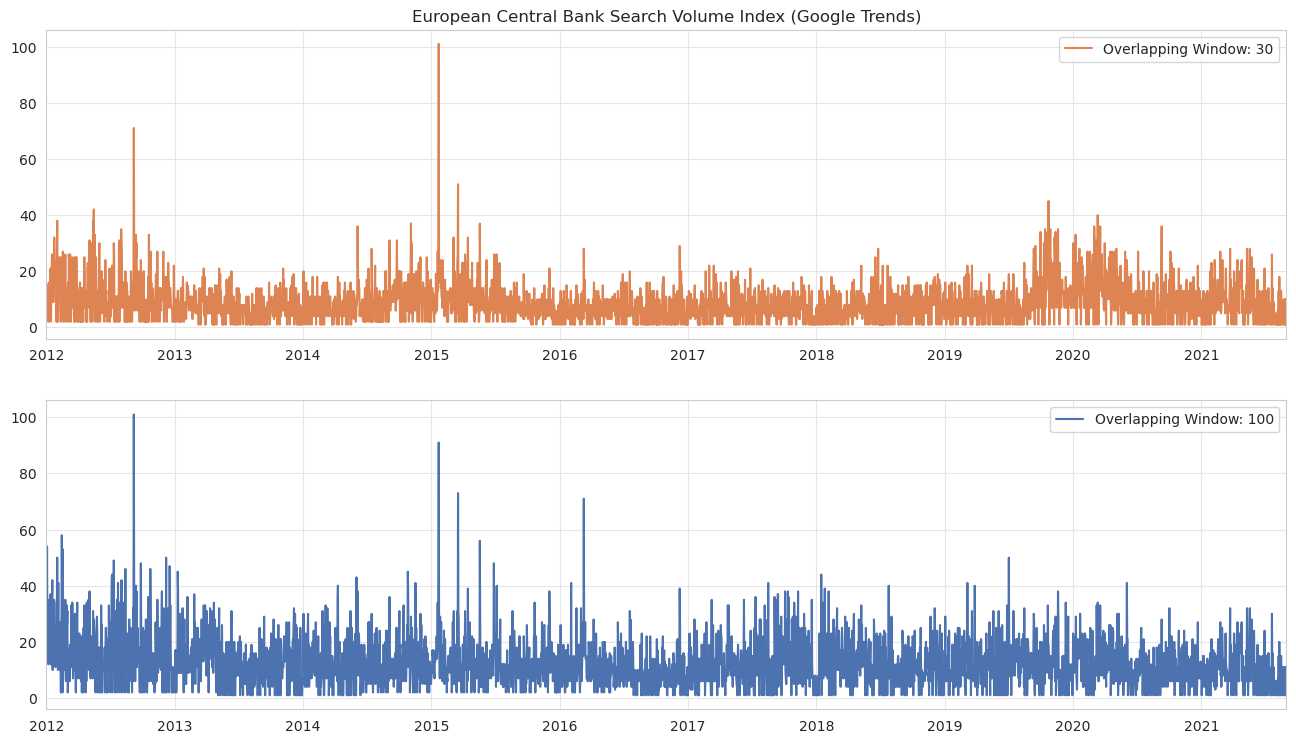

In [4]:
fig, ax = plt.subplots(2, 1)

ecb_daily_overlap.plot(y="ecb_30", ax=ax[0], c=palette[1], title="European Central Bank Search Volume Index (Google Trends)", label="Overlapping Window: 30")
ecb_daily_overlap.plot(y="ecb_100", ax=ax[1], label="Overlapping Window: 100")

plt.show()

# Load Daily Data (Retrieved with `Pytrends`)

This series is obtained with `pytrends`'s `get_daily_data`; however, it needs further tweaking. The data was downloaded, but we want to replace zeroes with ones and scale the series again. The scaling factor is simply the monthly value divided by 100, such that the daily observations for the month with the greates Search Volume Index won't be scaled (100 / 100 is 1, after all).

We also define a custom function to clean column names:

In [5]:
def clean_colnames(dataf: pd.DataFrame) -> pd.DataFrame:

    dataf.columns = dataf.columns.str.replace(" ", "_").str.lower()

    return dataf

In [6]:
ecb_daily_pytrends = (
    pd.read_csv(data_path + "pytrends-daily-ecb.csv", index_col=[0], parse_dates=[0])
    # rename with custom function
    .pipe(clean_colnames)
    .rename(
        columns={
            "european_central_bank_unscaled": "ecb_unscaled",
            "european_central_bank_monthly": "ecb_monthly",
            "european_central_bank": "ecb",
        }
    )
    .drop(["ispartial", "scale"], axis=1)
    .astype("int")
    .assign(
        ecb_unscaled=lambda x: x["ecb_unscaled"].add(1),
        ecb=lambda x: x["ecb_unscaled"] * x["ecb_monthly"] / 100,
    )
)

In [7]:
ecb_daily_pytrends

,ecb_unscaled,ecb_monthly,ecb
date,,,
2012-01-01,1,36,0.36
2012-01-02,1,36,0.36
2012-01-03,1,36,0.36
2012-01-04,1,36,0.36
2012-01-05,1,36,0.36
...,...,...,...
2021-08-27,1,12,0.12
2021-08-28,1,12,0.12
2021-08-29,1,12,0.12


## Problems

At first glance, we see that these values are very, very different from the ones we obtained from the overlapping method - clearly too small. The problem with this is that Google Trends data is not an index evaluated using the whole population of searches. Instead, it is evaluated out of a sample of searches - and we might just have been unlucky. If we retrieve the data for January 2012 and plot it against what we retrieve, we see the following:

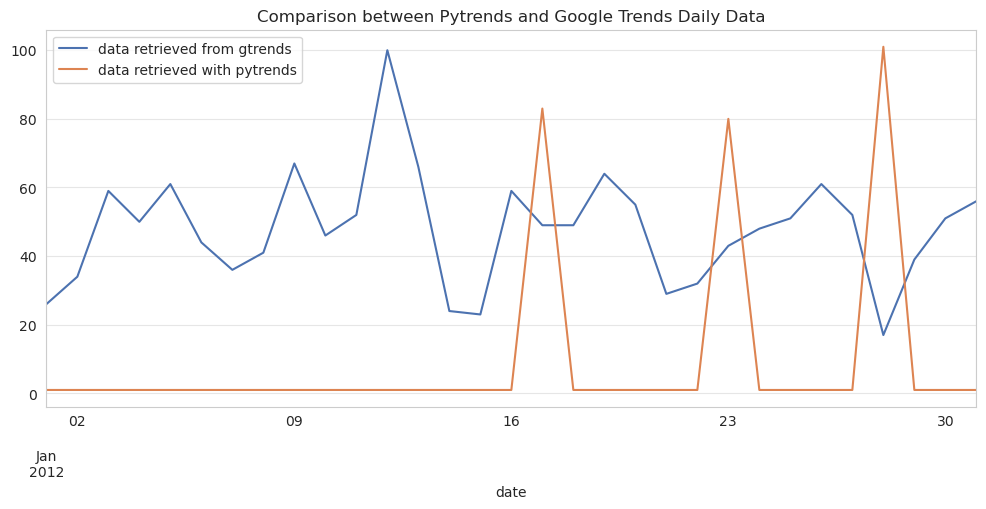

In [8]:
ecb_jan_2012 = pd.read_csv(data_path + "check-daily-ecb-jan_2012.csv", index_col=[0], parse_dates=[0], skiprows=2).asfreq("D")

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ecb_jan_2012.plot(
    y="European Central Bank: (Worldwide)",
    ax=ax,
    label="data retrieved from gtrends",
    title="Comparison between Pytrends and Google Trends Daily Data",
)
ecb_daily_pytrends["2012-01-01":"2012-01-31"].plot(
    y="ecb_unscaled", ax=ax, label="data retrieved with pytrends"
)

plt.show()

We can expect the same from the monthly data (spoiler: it is). If we compare the two time series (daily and monthly frequencies) we see how they virtually overlap:

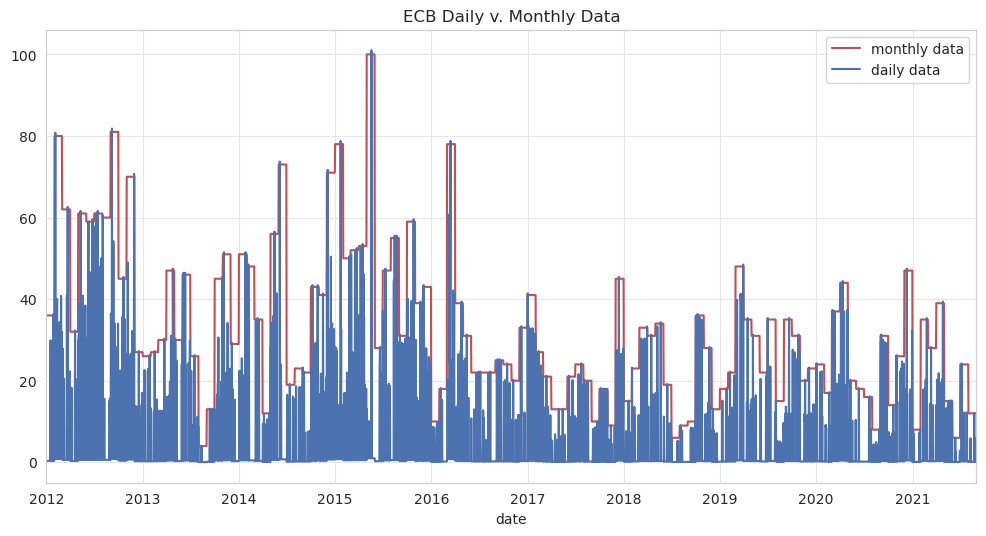

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ecb_daily_pytrends.plot(y="ecb_monthly", ax=ax, c=palette[3], label="monthly data", title="ECB Daily v. Monthly Data")
ecb_daily_pytrends.plot(y="ecb", ax=ax, label="daily data")

plt.show()

# Load Monthly Data

If we also look at the monthly data we retrieved alongside the other keywords (`Mario Draghi`, etc) we see there are other discrepancies:

In [10]:
ecb_monthly = (
    pd.read_csv(data_path + "gtrends-monthly-all.csv", index_col=[0], parse_dates=[0])
    .drop(["mario_draghi", "christine_lagarde", "euro" ], axis=1)
)

ecb_monthly

,european_central_bank
2012-01-01,89
2012-02-01,99
2012-03-01,77
2012-04-01,74
2012-05-01,86
...,...
2021-04-01,38
2021-05-01,46
2021-06-01,30
2021-07-01,31


The data points seem quite suspicious. If we look at the data retrieved directly from Google Trends (today, on 14/09/2021), we see that the values differ by a lot:

In [11]:
ecb_monthly_gtrends = (
    pd.read_csv(data_path + "check-monthly-ecb.csv", skiprows=2, index_col=[0], parse_dates=[0])
    .asfreq("MS")
    .rename({"European Central Bank: (Worldwide)": "ecb_monthly"}, axis=1)
)

ecb_monthly_gtrends

,ecb_monthly
Month,
2012-01-01,59
2012-02-01,60
2012-03-01,52
2012-04-01,47
2012-05-01,55
...,...
2021-04-01,33
2021-05-01,31
2021-06-01,32


We can compare these with the monthly data we retrieved with `pytrends` to get daily data:

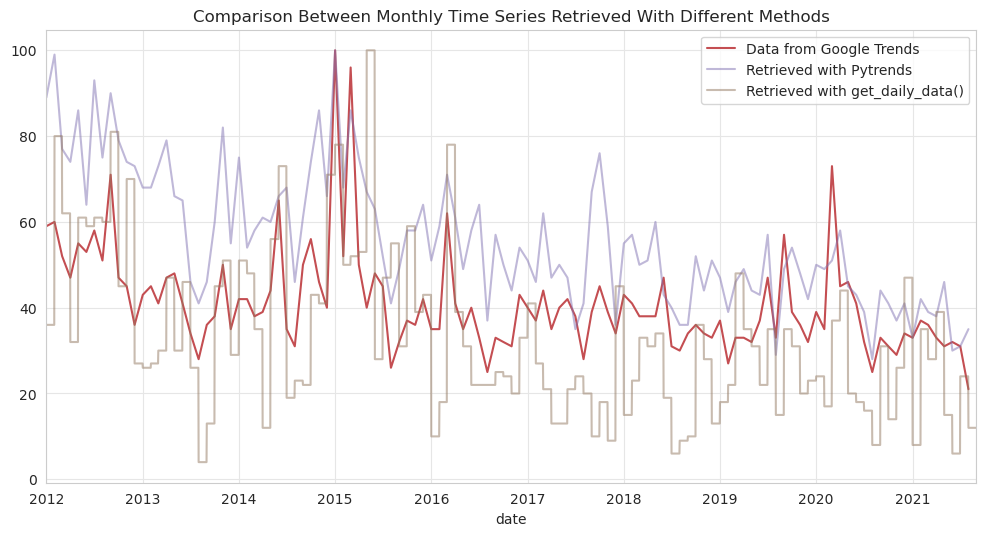

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

ecb_monthly_gtrends.plot(y="ecb_monthly", ax=ax, c=palette[3], label="Data from Google Trends")
ecb_monthly.plot(y="european_central_bank", ax=ax, c=palette[4], label="Retrieved with Pytrends", alpha=0.5)
ecb_daily_pytrends.plot(y="ecb_monthly", ax=ax, c=palette[5], label="Retrieved with get_daily_data()", alpha=0.5)

plt.title("Comparison between monthly time series retrieved with different methods".title())

plt.show()

fig.savefig("../03-figures/viz-comparison_monthly_data.jpeg")

# Resample Daily Overlapped Data and Compare with Monthly Data 

If we were to compare the resampled data with the monthly values we would achieve underwhelming results. After resample, we also need to scale the data to obtain a 0-100 range: 

In [13]:
def scale_df(x: float, max_of: pd.DataFrame, freq: str = "MS") -> float:

    max_x = max_of.resample(freq).sum().max()

    return x / max_x * 100

In [14]:
ecb_monthly_resample_avg = (
    ecb_daily_overlap
    .resample("MS")
    .mean()
    .assign(
        ecb_30 = lambda x: x["ecb_30"].div(ecb_daily_overlap.resample("MS").mean()["ecb_30"].max()) * 100,
        ecb_100 = lambda x: x["ecb_100"].div(ecb_daily_overlap.resample("MS").mean()["ecb_100"].max()) * 100
    )
    .astype("int")
)

ecb_monthly_resample_sum = (
    ecb_daily_overlap
    .resample("MS")
    .sum()
    .assign(
        ecb_30 = lambda x: x["ecb_30"] / ecb_daily_overlap.resample("MS").sum()["ecb_30"].max() * 100,
        ecb_100 = lambda x: x["ecb_100"] / ecb_daily_overlap.resample("MS").sum()["ecb_100"].max() * 100
    )
    .astype("int")
)

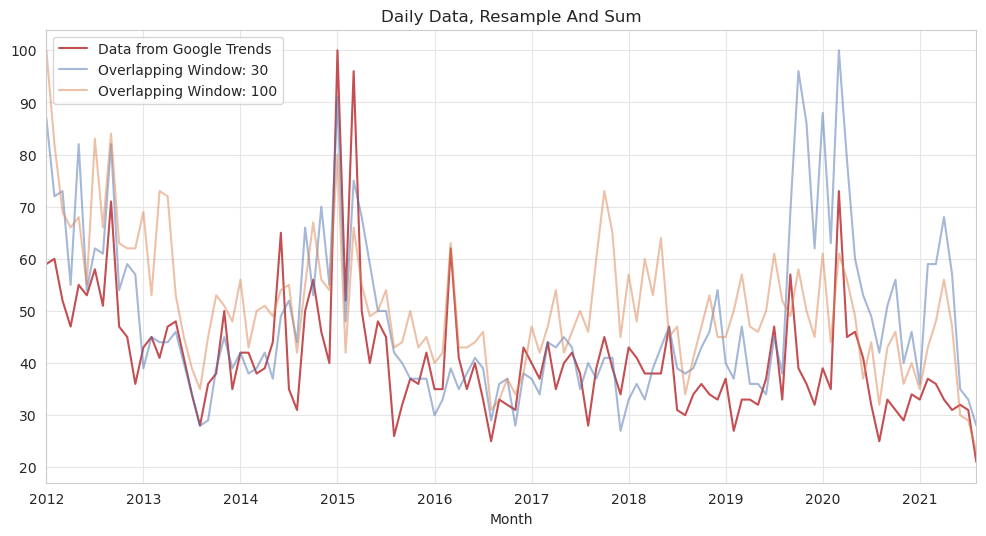

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

ecb_monthly_gtrends.plot(y="ecb_monthly", ax=ax, c=palette[3], label="Data from Google Trends")
ecb_monthly_resample_sum.plot(y="ecb_30", ax=ax, label="Overlapping Window: 30", alpha=0.5)
ecb_monthly_resample_sum.plot(y="ecb_100", ax=ax, label="Overlapping Window: 100", alpha=0.5)

plt.title("Daily data, resample and sum".title())

plt.show()

fig.savefig("../03-figures/viz-dailydata_resampled_sum.jpeg")

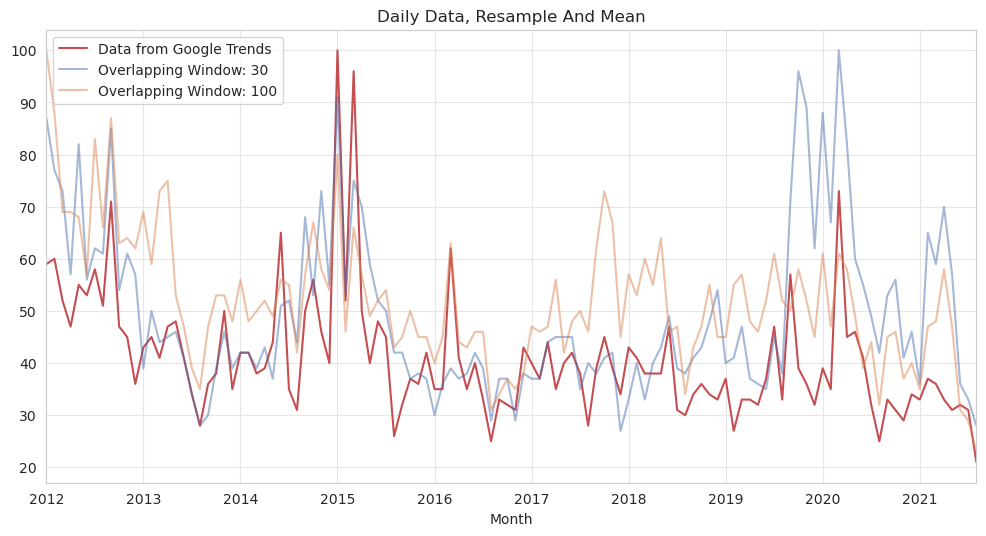

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ecb_monthly_gtrends.plot(y="ecb_monthly", ax=ax, c=palette[3], label="Data from Google Trends")
ecb_monthly_resample_avg.plot(y="ecb_30", ax=ax, label="Overlapping Window: 30", alpha=0.5)
ecb_monthly_resample_avg.plot(y="ecb_100", ax=ax, label="Overlapping Window: 100", alpha=0.5)

plt.title("Daily data, resample and mean".title())

plt.show()

fig.savefig("../03-figures/viz-dailydata_resampled_mean.jpeg")